# Pfeifen

In [3]:
%matplotlib inline
from IPython.display import display
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("../data/CongoDB.sqlite")

## Aufnahme

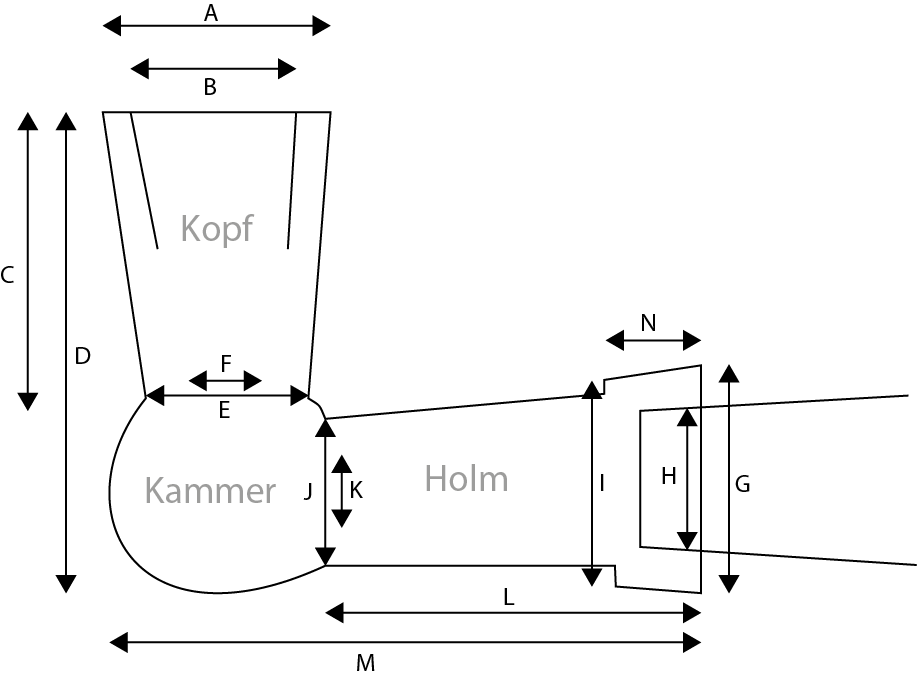

In [4]:
Image(filename='../misc/Auswertung_alt/Pfeifen/CongoPfeifenMaße.png') 

In [5]:
# manuell erstelle CSV-Datei einlesen
tab = pd.read_csv('../data/base/CongoPfeifen_CongoDB.csv', decimal = ',')
tab["Typ"] = tab["Typ"].replace(np.nan, 'k.a.')

display(tab.head())

,objID,Typ,Verz,A,B,C,D,E,F,G,H,I,J,K,L,M,M_inkAufhaengung,N,Notiz
0,1627,2,Kopf 1,40.0,16.0,51.0,NaN,27.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mass E Zylindrisch bis kurz vor Rand (Mass A)
1,1628,1,NaN,NaN,NaN,NaN,NaN,52.0,23.0,36.0,24.0,41.5,38.0,14.0,74.0,107.0,NaN,23.0,NaN
2,1629,1,1 (an Aufhaengung),NaN,NaN,NaN,NaN,35.0,15.0,32.0,18.5,38.0,36.0,12.0,80.0,103.0,NaN,27.0,NaN
3,1630,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,20.0,47.0,38.0,15.0,75.0,NaN,NaN,25.0,NaN
4,1631,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,16.0,44.0,43.0,14.0,85.0,NaN,NaN,45.0,NaN


Anzahl der Typen:

In [6]:
pd.DataFrame(tab.pivot_table(values = 'objID', index = 'Typ', aggfunc = len, margins = True))

,objID
Typ,
1.0,7.0
2.0,2.0
3.0,7.0
4.0,7.0
k.a.,3.0
All,26.0


> Idee: PCA mit den Verhältnissen der Maße rechnen lassen?

## Verbreitung

In [7]:
sql = """SELECT
            t_Obj.objID,
           't_Ort'.'ort_name' || ' (Fpl. ' || 't_ort'.'Kat-Nr' || ')' AS Ort,
           't_ort'.'Kat-Nr',
           't_Ort'.'ort_kurz' || ' ' || 't_Komplex'.'bef_nr' AS Befund,
            t_Komplex.bef_art,
            t_Obj.Anzahl,
            t_Obj.Notiz,
            t_Ort.y_lat,
            t_Ort.x_long,
            t_Ort.Ort_Fluss
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
# display(df.head())

In [8]:
# tabelle mit Taf.-Nr.
df_table = pd.read_csv('../data/processed/10_TafNr-objID_Liste.csv')
df_table_sub = df_table[['objID','TAF','OBJ']]
df_table_sub.head()

,objID,TAF,OBJ
0,68,1,1
1,204,1,2
2,5727,1,3
3,62,1,4
4,1469,2,1


> **ToDo:** [x] Aufnahme-Tab via merge mit DB verbinden:

In [9]:
df_merge = pd.merge(df, tab, on = 'objID')
# display(df_merge.head())

In [10]:
df_merge = pd.merge(df_merge, df_table_sub, on = 'objID', how='left')

In [11]:
df_merge.pivot_table(values = 'Anzahl', index = ['ort_fluss'], aggfunc = np.sum, fill_value = '')

ort_fluss
Likwala-Esobe    15
Ngoko             4
Sangha            6
Ubangi            1
Name: Anzahl, dtype: int64

In [12]:
df_pivot = df_merge.pivot_table(values = 'Anzahl', 
                                index = ['Kat-Nr', 'ort_fluss', 'Ort', 'Befund'], 
                                columns = 'Typ', 
                                aggfunc = np.sum, 
                                fill_value = '-', 
                                margins=True)
df_pivot = pd.DataFrame(df_pivot)

# Die Kat-Nr als Index wieder raus nehmen - war nur für die Sortierung wichtig
df_pivot.index = df_pivot.index.droplevel('Kat-Nr')

df_pivot.to_latex('../output/data/6-1_Pfeifen_Fpl-Typen.tex')

df_pivot

Typ                                                  1.0 2.0 3.0 4.0 k.a.  \
ort_fluss     Ort                      Befund                               
Ubangi        Boyoka (Fpl. 196)        BYO 85/101      -   -   -   1    -   
Sangha        Sangha Fkm 40 (Fpl. 240) SGH 40 87/040   -   -   -   -    1   
              Monjolomba (Fpl. 243)    MJL 87/101      -   -   -   2    -   
              Pikunda (Fpl. 255)       PIK 87/2        -   1   -   -    -   
              Molanda (Fpl. 258)       MLD 87/101      -   -   -   1    -   
              Mandombe (Fpl. 259)      MDB 87/101      -   -   1   -    -   
Ngoko         Pandama (Fpl. 276)       PDM 87/101      -   -   3   -    1   
Likwala-Esobe Bojenjo (Fpl. 292)       BJJ 87/101      -   -   -   2    -   
              Ebambe (Fpl. 297)        EBA 87/101      -   1   2   1    -   
              Mosenge (Fpl. 299)       MSG 87/101      -   -   1   -    -   
              Botongo (Fpl. 302)       BTG 87/101      1   -   -   -    1   
              Epena (Fpl. 303)          EPE 87/101      1   -   -   -    -   
              Munda (Fpl. 304)         MUN 87/1        1   -   -   -    -   
                                       MUN 87/101      4   -   -   -    -   
                                                       7   2   7   7    3   

Typ                                                    All  
ort_fluss     Ort                      Befund               
Ubangi        Boyoka (Fpl. 196)        BYO 85/101      1.0  
Sangha        Sangha Fkm 40 (Fpl. 240) SGH 40 87/040   1.0  
              Monjolomba (Fpl. 243)    MJL 87/101      2.0  
              Pikunda (Fpl. 255)       PIK 87/2        1.0  
              Molanda (Fpl. 258)       MLD 87/101      1.0  
              Mandombe (Fpl. 259)      MDB 87/101      1.0  
Ngoko         Pandama (Fpl. 276)       PDM 87/101      4.0  
Likwala-Esobe Bojenjo (Fpl. 292)       BJJ 87/101      2.0  
              Ebambe (Fpl. 297)        EBA 87/101      4.0  
              Mosenge (Fpl. 299)       MSG 87/101      1.0  
              Botongo (Fpl. 302)       BTG 87/101      2.0  
              Epena (Fpl. 303)          EPE 87/101      1.0  
              Munda (Fpl. 304)         MUN 87/1        1.0  
                                       MUN 87/101      4.0  
                                                      26.0

In [13]:
#df_pivot = df_pivot.reset_index()
#df_pivot.to_latex('../output/data/6-1_Pfeifen_Fpl-Typen.tex', index = False)


> **ToDo:**
> * [_] Multi-Index beibehalten
> * [_] Typen als Text-String anstatt Zahl
> * *oder einfach '.0' löschen?*

In [14]:
# a = df_pivot.reset_index()
# a

#len_LKW = len(a['ort_fluss'].loc[a['ort_fluss'] == 'Likwala-Esobe'])
#len_SGH = len(a['ort_fluss'].loc[a['ort_fluss'] == 'Sangha'])

#df_pivot = df_pivot.rename(index={'Likwala-Esobe':'\\multirow{7}{*}{Likwala-aux-Herbes}'})
#df_pivot = df_pivot.rename(index={'Sangha':'\\multirow{s}{*}{Sangha}'})

In [15]:
df_merge.sort_values(by = ['TAF', 'OBJ']).head()

,objID,Ort,Kat-Nr,Befund,bef_art,Anzahl,Notiz_x,y_lat,x_long,ort_fluss,...,I,J,K,L,M,M_inkAufhaengung,N,Notiz_y,TAF,OBJ
22,5691,Boyoka (Fpl. 196),196,BYO 85/101,Oberfl,1,Pfeife,1.089931,17.898659,Ubangi,...,NaN,24.0,9.0,NaN,NaN,NaN,NaN,NaN,5.0,6.0
19,4202,Sangha Fkm 40 (Fpl. 240),240,SGH 40 87/040,Oberfl,1,Pfeifenholm (?); Tonröhre mit 17/24 mm außen D...,-1.045511,16.932954,Sangha,...,NaN,20.0,6.0,NaN,NaN,NaN,NaN,G/J = 17/23,35.0,11.0
10,1725,Monjolomba (Fpl. 243),243,MJL 87/101,Oberfl,1,Pfeife: fast komplett,-0.684421,17.174576,Sangha,...,NaN,22.0,10.0,35.0,68.0,NaN,NaN,NaN,39.0,3.0
17,2698,Pikunda (Fpl. 255),255,PIK 87/2,Grube,1,Pfeife,0.549344,16.635736,Sangha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,13.0
24,5838,Pandama (Fpl. 276),276,PDM 87/101,Oberfl,1,Pfeife,1.783279,15.881677,Ngoko,...,13.0,NaN,NaN,NaN,29.0,10.0,NaN,90Grad (nach unten) an Kammer Aufhaengung (Loc...,65.0,8.0


In [16]:
df_merge.sort_values(by = ['Ort']).head()

,objID,Ort,Kat-Nr,Befund,bef_art,Anzahl,Notiz_x,y_lat,x_long,ort_fluss,...,I,J,K,L,M,M_inkAufhaengung,N,Notiz_y,TAF,OBJ
14,1731,Bojenjo (Fpl. 292),292,BJJ 87/101,Oberfl,1,Pfeife: Teil eines Holms,-0.006791,17.432057,Likwala-Esobe,...,NaN,30.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1726,Bojenjo (Fpl. 292),292,BJJ 87/101,Oberfl,1,Pfeife: Teile vom Holm & Verlängerung fehlen,-0.006791,17.432057,Likwala-Esobe,...,NaN,24.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1728,Botongo (Fpl. 302),302,BTG 87/101,Oberfl,1,Pfeife: Teil Kammer & Holm,0.854494,17.096583,Likwala-Esobe,...,NaN,34.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1729,Botongo (Fpl. 302),302,BTG 87/101,Oberfl,1,Pfeife: Holm & Kammer,0.854494,17.096583,Likwala-Esobe,...,41.0,33.0,11.0,48.0,99.0,NaN,25.0,45Grad an Kammer Aufhaengung,NaN,NaN
22,5691,Boyoka (Fpl. 196),196,BYO 85/101,Oberfl,1,Pfeife,1.089931,17.898659,Ubangi,...,NaN,24.0,9.0,NaN,NaN,NaN,NaN,NaN,5.0,6.0
